# Sérialisation, pickle, COVID

Ce notebook aborde les sujets évoqués dans le titre.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext pyensae

##  Sérialisation and pickle

La sérialisation consiste à rassembler tous les informations qu'on souhaite conserver dans un seul bloc contigü. Parmi les formats utilisées, on distingue les formats qu'on peut lire (json, csv, ...) et ceux qui ne peuvent être interprétés qu'avec le même logiciel ou langage qui les a produits.

La sérialisation est plus efficace quand le fichier produit n'est pas lisible car l'information est stockée telle qu'elle est dans la mémoire. Elle est plus facile à restaurer.

On crée un dataframe aléatoire et on écrire et lit sous différents formats.

In [3]:
import pandas
import numpy

mat = numpy.random.randn(10000, 50)
df = pandas.DataFrame(mat)
df.shape

(10000, 50)

In [4]:
df.size

500000

In [5]:
for c in range(1, 51):
    df["t%d" % c] = ["a" * c for i in range(df.shape[0])]

In [6]:
df.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50
0,-0.687078,-1.317984,0.485271,-0.274160,0.298888,0.485624,0.190280,0.938187,-0.934170,-0.200593,...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
1,-1.836182,0.003514,-0.591336,-0.404873,1.002684,-0.320763,0.846543,0.800089,-1.545944,1.314889,...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...


In [7]:
df.shape

(10000, 100)

In [8]:
df.size

1000000

### Format csv

In [9]:
%timeit df.to_csv('df.csv')

1.24 s ± 57.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%head df.csv -n 2

In [11]:
%timeit df2 = pandas.read_csv('df.csv')

318 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


La lecture est plus rapide que l'écriture. C'est souvent le cas avec les disques SSD, la lecture est plus rapide que l'écriture.

### Format pickle

Le format pickle n'est pas à proprement parler un format, python implémente un mécanisme pour sérialiser tout objet python, cela revient à rassembler tous les fragments de mémoires que cet objet occupe en un seul bloc qu'on écrit ensuite sur le disque, on qu'on envoie à une autre ordinateur connecté à internet.

In [12]:
import pickle

def pickle_obj(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

%timeit pickle_obj("df.pickle", df)

132 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
def load_pickle(name):
    with open(name, 'rb') as f:
        return pickle.load(f)
    
%timeit df = load_pickle('df.pickle')

67.3 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


La lecture est l'écriture sont très rapides car ce qui est écrit ou lu est directement ce qu'il y a en mémoire. En contrepartie, ces informations ne peuvent être relus que depuis python et souvent depuis la même version de python.

## Modèle épidémiologique (SIRD)

Etrangement, il n'était pas possible d'accéder aux données de l'épidémie le jour du TD car le site [data.gouv.fr](https://www.data.gouv.fr/fr/) était inacessible suite à une [panne chez OVH](https://www.lemonde.fr/pixels/article/2021/10/13/le-fournisseur-de-services-cloud-et-hebergeur-ovhcloud-touche-par-une-panne_6098154_4408996.html).

* $\frac{dS}{dt} = - \beta \frac{S I}{N}$
* $\frac{dI}{dt} = \frac{\beta S I}{N} - \mu I - \nu I$
* $\frac{dD}{dt} = \nu I$
* $\frac{dR}{dt} = \mu I$

Comme les vraies données sont inaccessibles, on s'intéresse à des données simulées.

### Simulation

In [14]:
def iteration(S, I, R, D, beta, mu, nu, N):
    dR = I * mu
    dD = I * nu
    dS = - S * I * beta / N
    dI = -dS - dR - dD
    return S + dS, I + dI, R + dR, D + dD

iteration(10, 1, 0, 0, 0.1, 0.1, 0.1, 11)

(9.909090909090908, 0.8909090909090909, 0.1, 0.1)

In [15]:
def simulation(n_iter, S, I, R, D, beta, mu, nu):
    sim = numpy.zeros((n_iter + 1, 4))
    sim[0, :] = numpy.array([S, I, R, D]).ravel()
    N = S + I + R + D
    for i in range(n_iter):
        S, I, R, D = iteration(S, I, R, D, beta, mu, nu, N)
        sim[i + 1, :] = numpy.array([S, I, R, D]).ravel()
    return sim

simulation(2, 10, 1, 0, 0, 0.1, 0.1, 0.1)

array([[10.        ,  1.        ,  0.        ,  0.        ],
       [ 9.90909091,  0.89090909,  0.1       ,  0.1       ],
       [ 9.82883546,  0.79298272,  0.18909091,  0.18909091]])

### Visualisation

In [16]:
%matplotlib inline

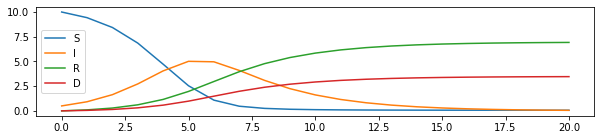

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
sim = simulation(20, 10, 0.5, 0, 0, 1.2, 0.2, 0.1)
df = pandas.DataFrame(sim, columns=['S', 'I', 'R', 'D'])
df.plot(ax=ax);

### Estimation des paramètres

Une fois qu'on a des données, on peut essayer de retrouver la paramètres de la simulation. Mais auparavant, on simule des données un peu plus bruitées en changeant les paramètres du modèle tous les jours.

In [18]:
def simulation_bruitee(n_iter, S, I, R, D, beta, mu, nu):
    sim = numpy.zeros((n_iter + 1, 4))
    sim[0, :] = numpy.array([S, I, R, D]).ravel()
    N = S + I + R + D
    for i in range(n_iter):
        b = numpy.random.randn(1) * beta / 5 + beta
        m = numpy.random.randn(1) * mu / 5 + mu
        n = numpy.random.randn(1) * nu / 5 + nu
        S, I, R, D = iteration(S, I, R, D, b, m, n, N)
        sim[i + 1, :] = numpy.array([S, I, R, D]).ravel()
    return sim

simulation_bruitee(2, 10, 1, 0, 0, 0.1, 0.1, 0.1)

array([[10.        ,  1.        ,  0.        ,  0.        ],
       [ 9.91325458,  0.93586211,  0.08147788,  0.06940543],
       [ 9.83228297,  0.82054609,  0.17866666,  0.16850428]])

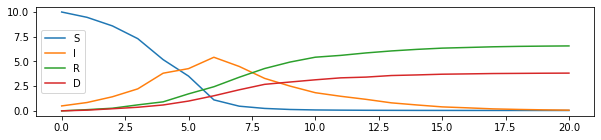

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
sim_bruit = simulation_bruitee(20, 10, 0.5, 0, 0, 1.2, 0.2, 0.1)
df = pandas.DataFrame(sim_bruit, columns=['S', 'I', 'R', 'D'])
df.plot(ax=ax);

#### Première idée

On calcule les paramètres chaque jour à partir de la définition du modèle.

In [20]:
def estimation_coefficient(sim):
    N = sim.sum(axis=1)
    diff = sim[1:] - sim[:-1]
    mu = diff[:, 2] / sim[:-1, 1]
    nu = diff[:, 3] / sim[:-1, 1]
    beta = - diff[:, 0] / (sim[:-1, 1] * sim[:-1, 0]) * N[:-1]
    return dict(beta=beta, mu=mu, nu=nu)

df = pandas.DataFrame(estimation_coefficient(sim_bruit))
df.head(n=1)

,beta,mu,nu
0,1.129296,0.241642,0.145303


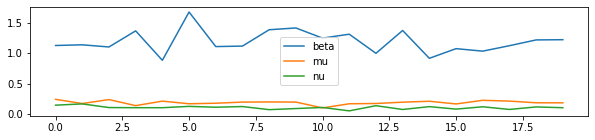

In [21]:
df.plot(figsize=(10,2));

On pourrait imaginer que les paramètres cherchés soient égaux à la moyenne des valeurs obtenues pour chaque jour. Encore faudrait-il le prouver ou trouver un contre exemple.

#### Seconde idée : problèmes d'optimisation

On cherche à transformer le problème d'estimation en un problème d'optimisation de telle sorte que les paramètres en sont la solution. L'idée de simuler en fonction d'un jeu de paramètres puis de calculer une distance entre cette simulation et les données observées.

Le problème de cette solution est qu'il faut essayer plein de valeur, au hasard pour faire simple. Donc on se sert de la fonction précédente comme point de départ et on tire des valeurs tout autour.

In [22]:
def distance_sim(obs, sim):
    return ((obs - sim) ** 2).sum() / obs.size

distance_sim(sim, sim_bruit)

0.09110736444463925

In [23]:
def optimisation(obs):
    est = estimation_coefficient(obs)
    b0 = est['beta'].mean()
    m0 = est['mu'].mean()
    n0 = est['nu'].mean()
    n_iter = obs.shape[0] - 1
    S, I, R, D = obs[0]
    beta, mu, nu = b0, m0, n0
    distance = distance_sim(obs, simulation(n_iter, S, I, R, D, b0, m0, n0))
    distance0 = distance
    for i in range(0, 100):
        b = numpy.random.randn(1) * b0 / 5 + b0
        m = numpy.random.randn(1) * m0 / 5 + m0
        n = numpy.random.randn(1) * n0 / 5 + n0      
        sim = simulation(n_iter, S, I, R, D, b, m, n)
        d = distance_sim(obs, sim)
        if distance is None or d < distance:
            distance = d
            beta, mu, nu = b, m, n
    return dict(b0=b0, mu0=m0, nu0=n0, beta=beta, mu=mu, nu=nu,
                distance=distance, distance0=distance0)

optimisation(sim_bruit)

{'b0': 1.1949449618580996,
 'mu0': 0.18786221862533412,
 'nu0': 0.10660548950608435,
 'beta': array([1.15830814]),
 'mu': array([0.17720381]),
 'nu': array([0.10532943]),
 'distance': 0.021211456859144485,
 'distance0': 0.043139240901541635}

`distance0` la distance entre la simulation obtenue avec les paramètes de la première méthode, `distance` celle de la seconde et elle est plus petite. Cela répond à la question qu'on se posait ci-dessus.